### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [8]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [12]:
cap = cv2.VideoCapture(2)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [93]:
!labelme

2024-03-08 01:43:37,448 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\deeja\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [15]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [17]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [18]:
images.as_numpy_iterator().next()

b'data\\images\\fbcd22a0-dcb7-11ee-8c23-001a7dda7112.jpg'

In [19]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [20]:
images = images.map(load_image)

In [21]:
images.as_numpy_iterator().next()

array([[[226, 231, 225],
        [226, 231, 225],
        [226, 231, 225],
        ...,
        [191, 192, 187],
        [189, 190, 185],
        [188, 189, 184]],

       [[226, 231, 225],
        [226, 231, 225],
        [226, 231, 225],
        ...,
        [192, 193, 188],
        [190, 191, 186],
        [189, 190, 185]],

       [[226, 231, 225],
        [226, 231, 225],
        [227, 232, 226],
        ...,
        [194, 195, 190],
        [192, 193, 188],
        [191, 192, 187]],

       ...,

       [[ 72,  67,  71],
        [ 71,  69,  72],
        [ 75,  70,  74],
        ...,
        [116, 111, 108],
        [116, 111, 108],
        [115, 110, 107]],

       [[ 68,  66,  71],
        [ 69,  68,  73],
        [ 72,  70,  75],
        ...,
        [115, 110, 107],
        [114, 109, 106],
        [113, 108, 105]],

       [[ 65,  64,  70],
        [ 67,  66,  72],
        [ 69,  68,  74],
        ...,
        [114, 109, 106],
        [113, 108, 105],
        [112, 107, 104]]

In [22]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [23]:
image_generator = images.batch(4).as_numpy_iterator()

In [24]:
plot_images = image_generator.next()

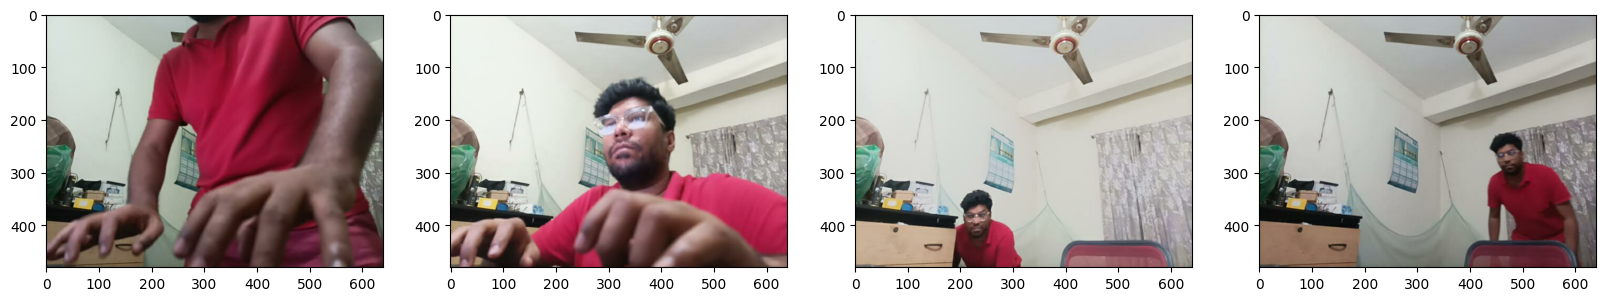

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [26]:
120*.7 # 63 to train

84.0

In [27]:
120*.15 # 14 and 13 to test and val

18.0

### 3.2 Move the Matching Labels

In [28]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [4]:
import albumentations as alb

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [6]:
img = cv2.imread(os.path.join('data','train', 'images','26afdb13-dcb8-11ee-9b9a-001a7dda7112.jpg'))

In [7]:
with open(os.path.join('data', 'train', 'labels', '26afdb13-dcb8-11ee-9b9a-001a7dda7112.json'), 'r') as f:
    label = json.load(f)

In [8]:
label['shapes'][0]['points']

[[399.88505747126436, 212.41379310344828],
 [484.94252873563215, 360.68965517241384]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [9]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [10]:
coords

[399.88505747126436,
 212.41379310344828,
 484.94252873563215,
 360.68965517241384]

In [11]:
coords = list(np.divide(coords, [640,480,640,480]))

In [12]:
coords

[0.6248204022988506,
 0.4425287356321839,
 0.7577227011494252,
 0.7514367816091955]

### 4.4 Apply Augmentations and View Results

In [13]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [14]:
augmented['bboxes'][0][2:]

(0.9243167305236268, 0.5457471264367816)

In [15]:
augmented['bboxes']

[(0.735300127713921,
  0.2162452107279692,
  0.9243167305236268,
  0.5457471264367816)]

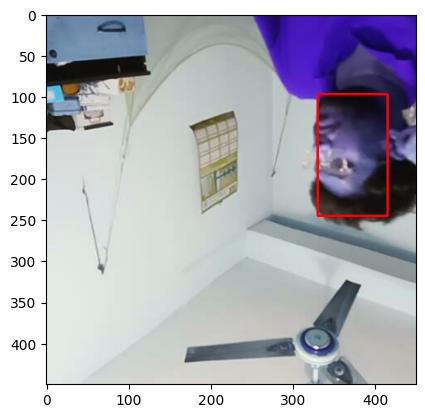

In [16]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [46]:
train_images.as_numpy_iterator().next()

array([[[0.7254902 , 0.634375  , 0.5155637 ],
        [0.7354779 , 0.63351715, 0.5276348 ],
        [0.7294118 , 0.627451  , 0.52156866],
        ...,
        [0.7297794 , 0.5959559 , 0.53909314],
        [0.7002451 , 0.57530636, 0.5310049 ],
        [0.7015319 , 0.5470588 , 0.518076  ]],

       [[0.7254902 , 0.627451  , 0.50980395],
        [0.7254902 , 0.62395835, 0.5167892 ],
        [0.7259804 , 0.62352943, 0.5176471 ],
        ...,
        [0.6946691 , 0.5779412 , 0.51715684],
        [0.7028799 , 0.5244485 , 0.5009804 ],
        [0.63394606, 0.40177697, 0.4079657 ]],

       [[0.7372549 , 0.6392157 , 0.51911765],
        [0.72898287, 0.63094366, 0.51329654],
        [0.7259804 , 0.6240196 , 0.5181373 ],
        ...,
        [0.72205883, 0.4795956 , 0.4824755 ],
        [0.70484066, 0.328799  , 0.39258578],
        [0.54362744, 0.11568628, 0.20931372]],

       ...,

       [[0.9607843 , 0.98039216, 0.95686275],
        [0.9607843 , 0.98039216, 0.9578431 ],
        [0.9607843 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [47]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [48]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [49]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.624 , 0.2261, 0.9253, 0.599 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [52]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [53]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [54]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [55]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [56]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.625 , 0.2917, 0.8906, 0.6416],
        [0.4526, 0.4558, 0.5522, 0.5757],
        [0.3147, 0.3423, 0.3787, 0.4421],
        [0.3604, 0.1073, 0.465 , 0.2632],
        [0.4514, 0.535 , 0.518 , 0.637 ],
        [0.365 , 0.3406, 0.631 , 0.6904],
        [0.4873, 0.2917, 0.753 , 0.6416],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 7.3 View Images and Annotations

In [57]:
data_samples = train.as_numpy_iterator()

In [58]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


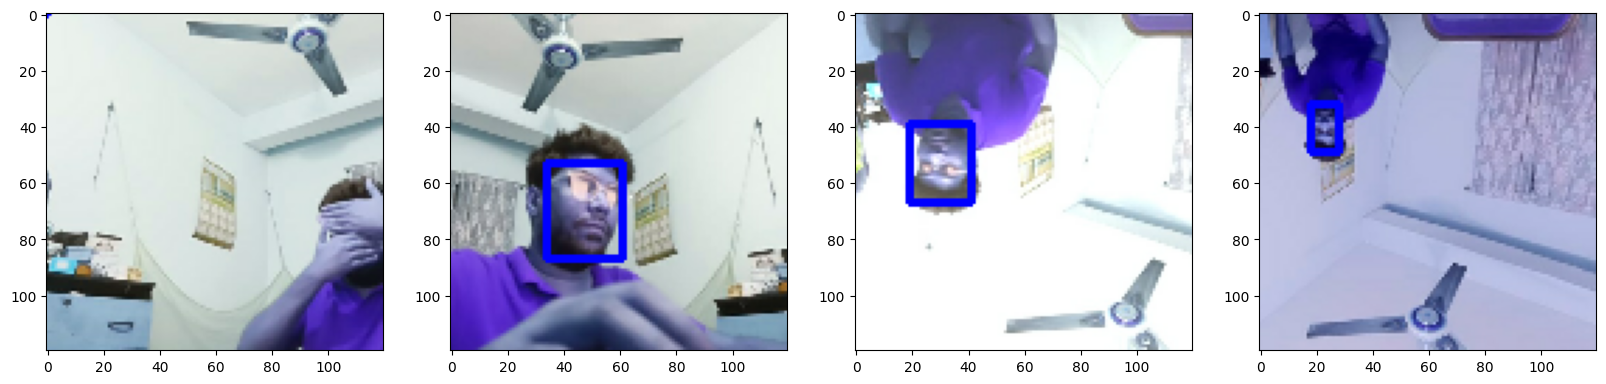

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = res[0][idx].copy()  # Make a copy to avoid modifying the original array
    sample_coords = res[1][1][idx]
    
    # Draw rectangle on the copied image
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    # Convert the image to a NumPy array for plotting
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    ax[idx].imshow(sample_image)

plt.show()

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [61]:
vgg = VGG16(include_top=False)

In [62]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [63]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [64]:
facetracker = build_model()

In [65]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [66]:
X, y = train.as_numpy_iterator().next()

In [67]:
X.shape

(8, 120, 120, 3)

In [68]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 203ms/step


In [69]:
classes, coords

(array([[0.62238824],
        [0.6474293 ],
        [0.6264616 ],
        [0.6169623 ],
        [0.5625358 ],
        [0.6485305 ],
        [0.63186926],
        [0.6010268 ]], dtype=float32),
 array([[0.61117333, 0.5605209 , 0.51926875, 0.44670534],
        [0.57440734, 0.4530302 , 0.47143543, 0.47343388],
        [0.5815499 , 0.5271237 , 0.5016475 , 0.53163564],
        [0.69187045, 0.57150394, 0.5018787 , 0.5912749 ],
        [0.65606755, 0.6349352 , 0.5395272 , 0.6153043 ],
        [0.60332805, 0.7100603 , 0.47555697, 0.6400575 ],
        [0.58413607, 0.5077708 , 0.46371344, 0.48475355],
        [0.63621104, 0.5288111 , 0.53510815, 0.53739727]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [70]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [71]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [72]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [73]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [74]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.601544>

In [75]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.68030167>

In [76]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.601544>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [77]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [78]:
model = FaceTracker(facetracker)

In [79]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [80]:
logdir='logs'

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [82]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
630/630 [==============================] - 37s 45ms/step - total_loss: 0.5615 - class_loss: 0.2205 - regress_loss: 0.4512 - val_total_loss: 0.0741 - val_class_loss: 0.0081 - val_regress_loss: 0.0700
Epoch 2/10
630/630 [==============================] - 32s 40ms/step - total_loss: 0.0781 - class_loss: 0.0259 - regress_loss: 0.0652 - val_total_loss: 0.0312 - val_class_loss: 0.0214 - val_regress_loss: 0.0205
Epoch 3/10
630/630 [==============================] - 32s 40ms/step - total_loss: 0.0282 - class_loss: 0.0118 - regress_loss: 0.0224 - val_total_loss: 0.0178 - val_class_loss: 0.0012 - val_regress_loss: 0.0172
Epoch 4/10
630/630 [==============================] - 32s 40ms/step - total_loss: 0.0434 - class_loss: 0.0182 - regress_loss: 0.0343 - val_total_loss: 0.0134 - val_class_loss: 4.1077e-04 - val_regress_loss: 0.0132
Epoch 5/10
630/630 [==============================] - 32s 40ms/step - total_loss: 0.0269 - class_loss: 0.0094 - regress_loss: 0.0222 - val_total_loss: 0.018

### 10.3 Plot Performance

In [83]:
hist.history

{'total_loss': [0.07907870411872864,
  0.014256259426474571,
  0.013025792315602303,
  0.026143895462155342,
  0.07583235949277878,
  0.004915295168757439,
  0.0052885389886796474,
  0.002289836760610342,
  0.009953843429684639,
  0.009181331843137741],
 'class_loss': [0.013578694313764572,
  0.00013896095333620906,
  0.003037073416635394,
  0.00033224449725821614,
  0.009828870184719563,
  1.759115548338741e-05,
  0.000603980734013021,
  5.131481520948e-05,
  0.002101140795275569,
  0.0010968054411932826],
 'regress_loss': [0.0722893550992012,
  0.014186779037117958,
  0.011507255956530571,
  0.02597777359187603,
  0.07091792672872543,
  0.00490649975836277,
  0.00498654879629612,
  0.002264179289340973,
  0.00890327338129282,
  0.008632929064333439],
 'val_total_loss': [0.0740717276930809,
  0.031228026375174522,
  0.017806341871619225,
  0.013430412858724594,
  0.018512707203626633,
  0.007305823266506195,
  0.002891424112021923,
  0.00786754209548235,
  0.012389629147946835,
  0.00

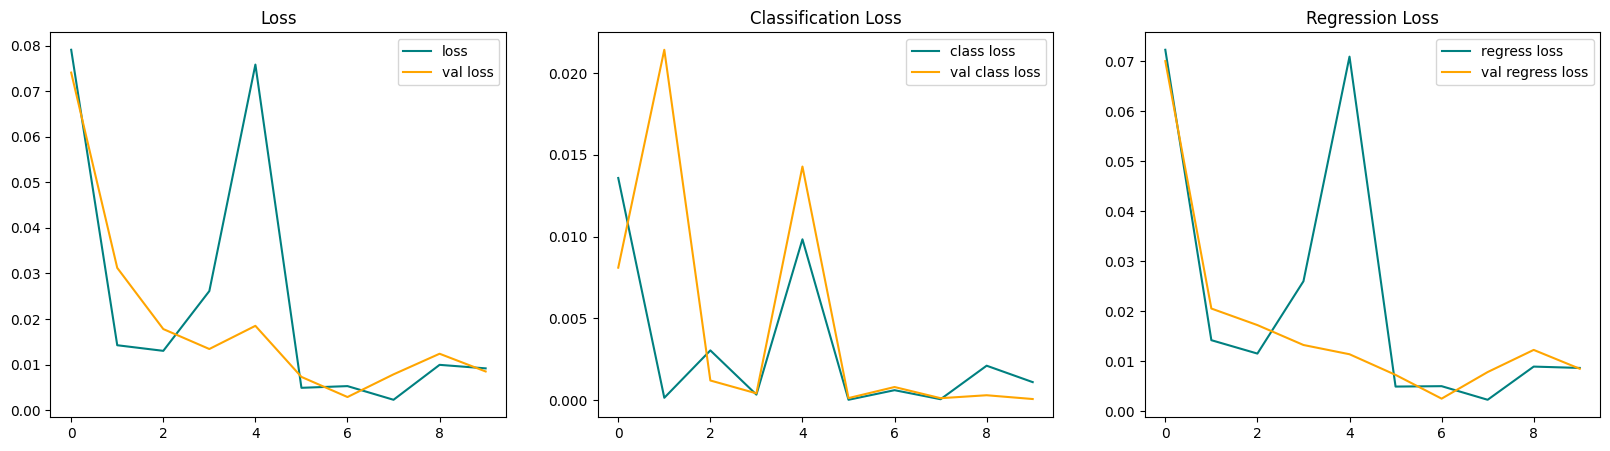

In [84]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [85]:
test_data = test.as_numpy_iterator()

In [86]:
test_sample = test_data.next()

In [87]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


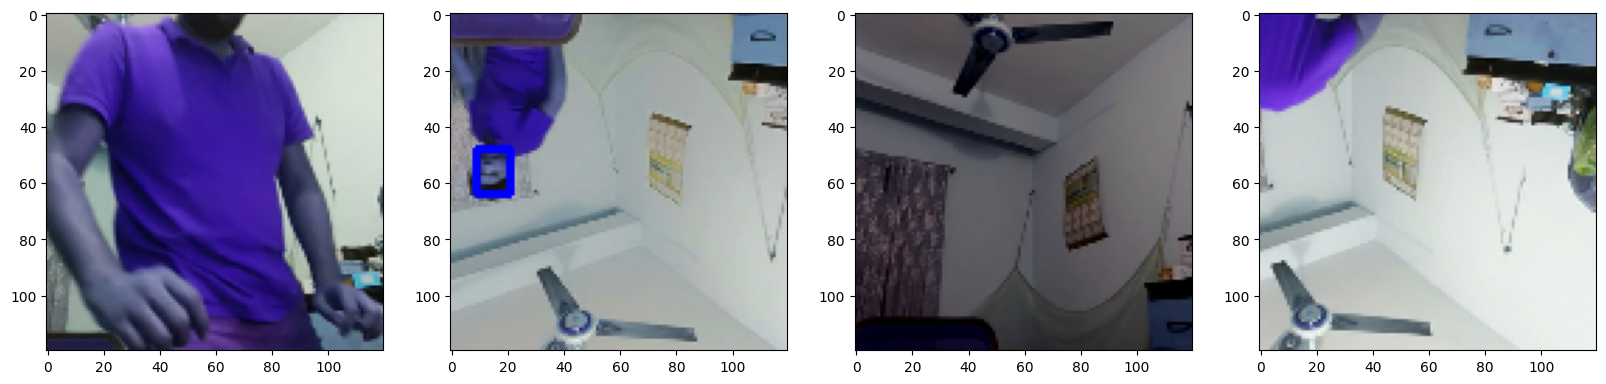

In [88]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Make a copy of the image
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
    
    # Convert the image to RGB format for matplotlib
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(sample_image)

plt.show()

### 11.2 Save the Model

In [89]:
from tensorflow.keras.models import load_model

In [90]:
facetracker.save('facetracker.h5')

In [91]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [96]:
cap = cv2.VideoCapture(2)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    confidence_score = yhat[0][0][0]  # Access the confidence score
    
    # Access the detected face coordinates
    sample_coords = yhat[1][0]
    
    # Define a threshold for confidence
    confidence_threshold = 0.5
    
    # Check if confidence score is above threshold and coordinates are valid
    if confidence_score > confidence_threshold and all(coord >= 0 for coord in sample_coords):
        # Draw the rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)), 
                      (255, 0, 0), 2)
        
        # Draw the label rectangle
        label_top_left = (int(np.multiply(sample_coords[0], 450)), int(np.multiply(sample_coords[1], 450)) - 30)
        label_bottom_right = (label_top_left[0] + 80, label_top_left[1] + 30)
        cv2.rectangle(frame, label_top_left, label_bottom_right, (255, 0, 0), -1)
        
        # Draw the text
        cv2.putText(frame, 'shaikat_face', (label_top_left[0], label_top_left[1] + 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceDetect', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 16ms/step
